# Models

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import os
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

### Chargement des données

On charge les données et on encode les variable catégorielles, on modifie les labels de sortie pour avoir 'none' et 'malveillant'

In [2]:
df0=pd.read_csv("../data/final/Credential_Access.csv")
df1=pd.read_csv("../data/final/Defense_Evasion.csv")
df2=pd.read_csv("../data/final/Discovery.csv")
df3=pd.read_csv("../data/final/Exfiltration.csv")
df4=pd.read_csv("../data/final/Initial_Access.csv")
df5=pd.read_csv("../data/final/none.csv")
df6=pd.read_csv("../data/final/Persistence.csv")
df7=pd.read_csv("../data/final/Privilege_Escalation.csv")
df8=pd.read_csv("../data/final/Reconnaissance.csv")
listeDatasets=[df0,df1,df2,df3,df4,df5,df6,df7,df8]

categorical_columns = ['conn_state', 'protocol', 'service', 'history', 'label_tactic']
  
#Gestion des dates
for i in range(len(listeDatasets)):
    df=listeDatasets[i]

     # Modifier la colonne
    df['label_tactic'] = df['label_tactic'].apply(lambda x: "malveillant" if x != "none" else x)

    df['ts'] = pd.to_datetime(df['ts'], unit='s')
    df['year'] = df['ts'].dt.year
    df['month'] = df['ts'].dt.month
    df['day'] = df['ts'].dt.day
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['seconde'] = df['ts'].dt.second
    df['dayofweek'] = df['ts'].dt.dayofweek  # 0=lundi, 6=dimanche

    # Caractéristiques cycliques pour l'heure (pour préserver la nature cyclique)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Caractéristiques cycliques pour le jour de la semaine
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

    # Trier par timestamp pour calculer les différences temporelles
    df = df.sort_values('ts')
    df['time_since_last'] = df['ts'].diff().dt.total_seconds()

    # Remplacer la première valeur NaN par 0 ou une autre valeur appropriée
    df['time_since_last'] = df['time_since_last'].fillna(0)

    df=df.drop(['ts'], axis=1)

    #Gestion des adresses IP
    df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    df['dest_ip'] = df['dest_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    
    #Une IPV6 est un trop grand nombre, on ne peut pas le mettre en entier
    #On normalise donc les ip en divisant par la plus grande valeur possible (pour etre entre 0 et 1)
    df['src_ip'] = df['src_ip']/(2**128 - 1) # 2^128 est le max pour IPv6 car codée sur 128 bits
    df['dest_ip'] = df['dest_ip']/(2**128 - 1)

    df['src_ip']=df['src_ip'].astype(float)
    df['dest_ip']=df['dest_ip'].astype(float)

    listeDatasets[i]=df
# Créer et stocker les encodeurs
encoders = {}

for col in categorical_columns:
    # Collecter toutes les valeurs uniques de TOUS les datasets
    all_values = pd.concat([df[col] for df in listeDatasets]).unique()
    
    # Créer et ajuster l'encodeur sur toutes les valeurs possibles
    encoders[col] = LabelEncoder().fit(all_values)
    
    # Appliquer l'encodeur à chaque dataset
    for df in listeDatasets:
        df[col] = encoders[col].transform(df[col])


Affichage de la structure d'un dataset encodé

In [3]:
print(listeDatasets[1].columns)
print(listeDatasets[7]["dest_ip"].head())

Index(['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history', 'src_ip', 'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'label_tactic', 'year', 'month', 'day',
       'hour', 'minute', 'seconde', 'dayofweek', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'time_since_last'],
      dtype='object')
291    7.067394e-30
318    7.067402e-30
279    7.067397e-30
268    7.067402e-30
253    7.067402e-30
Name: dest_ip, dtype: float64


### Separation des données

In [4]:
#Diviser chaque dataset en train/test (80/20)
train_dfs = []
test_dfs = []

for df in listeDatasets:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

#Concaténer les ensembles
combined_train = pd.concat(train_dfs)
combined_test = pd.concat(test_dfs)

print(combined_test.head())
print(combined_test.shape)
print(combined_train.columns)

       conn_state  duration  local_orig  local_resp  protocol  service  \
10911           6  2.693028           0           0         1       18   
37154           6  0.028394           0           0         1       18   
15733           6  2.110349           0           0         1       18   
27523           6  0.025471           0           0         1       18   
7581            6  0.030238           0           0         1       18   

       history        src_ip  src_port  orig_bytes  ...  day  hour  minute  \
10911       33  7.067402e-30     36643      1062.0  ...   29    23      13   
37154       33  7.067398e-30     45863       686.0  ...   14    10      18   
15733       33  7.067403e-30     34295      1046.0  ...   19    19       5   
27523       33  7.067397e-30     41475       686.0  ...   23    21       0   
7581        33  7.067396e-30     35003       686.0  ...   29    21      18   

       seconde  dayofweek  hour_sin  hour_cos   dow_sin   dow_cos  \
10911       14   

### Entrainement du modèle

In [9]:
features = ['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history','src_ip',  'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'year', 'month', 'day',
       'hour', 'minute', 'seconde', 'dayofweek', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'time_since_last']

label='label_tactic'

# Préparer X et y
X_train = combined_train[features]
y_train = combined_train[label]
X_test = combined_test[features]
y_test = combined_test[label]

# Créer les datasets LightGBM
categorical_indices = [features.index(col) for col in categorical_columns[:-1] ]#On recupere l'index de chaque colonne catégorielle (sauf le label)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_indices)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)



# 9. Paramètres LightGBM
num_classes = len(encoders['label_tactic'].classes_)
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': 1
}

# 10. Entraîner le modèle
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1712479, number of used features: 30
[LightGBM] [Info] Start training from score -1.350555
[LightGBM] [Info] Start training from score -0.299885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Affichage d'un arbre

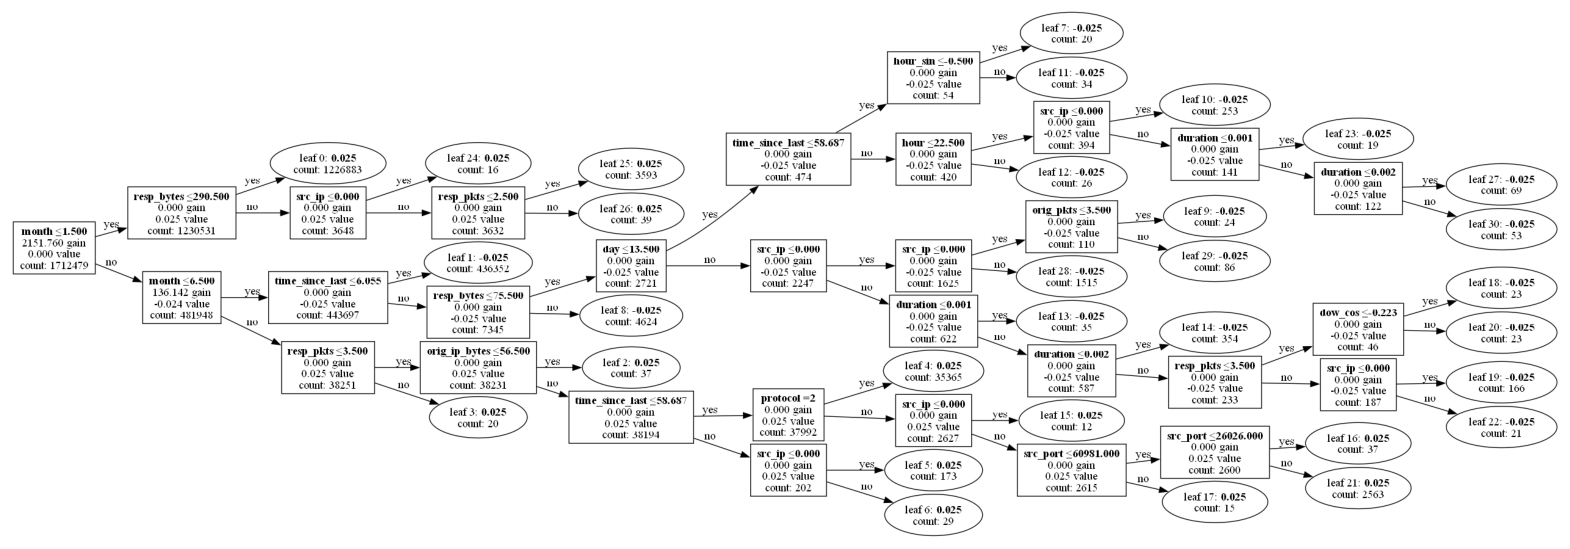

In [10]:
# Afficher l'arbre (exemple pour le premier arbre)
ax = lgb.plot_tree(gbm, tree_index=-1, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

plt.show()

### Evaluation du modèle

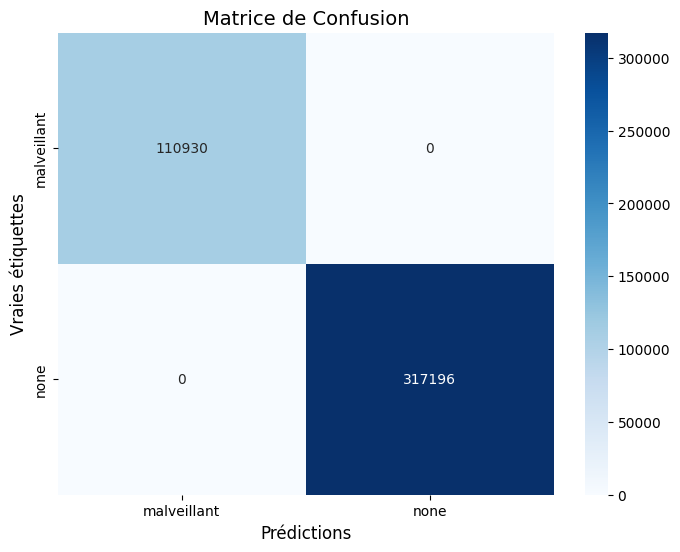


Rapport de classification:
              precision    recall  f1-score   support

 malveillant       1.00      1.00      1.00    110930
        none       1.00      1.00      1.00    317196

    accuracy                           1.00    428126
   macro avg       1.00      1.00      1.00    428126
weighted avg       1.00      1.00      1.00    428126



In [11]:
# 11. Évaluer le modèle
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_class = np.argmax(y_pred, axis=1)

# Reconvertir en labels textuels pour l'évaluation
y_pred_labels = encoders['label_tactic'].inverse_transform(y_pred_class)
y_test_labels = encoders['label_tactic'].inverse_transform(y_test)

# Afficher les résultats
from sklearn.metrics import classification_report, confusion_matrix
cm=confusion_matrix(y_test, y_pred_class)

labels = np.unique(y_test_labels)

# Afficher sous forme de heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels , yticklabels=labels)
#annot= affichage des valeurs dans les carrés  fmt = formatage des valeurs, d = entier (par exemple si c'est 0.87, il sera affiché 1).

# Ajouter les labels APRÈS avoir tracé la heatmap
ax.set_xlabel('Prédictions', fontsize=12)
ax.set_ylabel('Vraies étiquettes', fontsize=12)
ax.set_title('Matrice de Confusion', fontsize=14)
plt.show()



print("\nRapport de classification:")
print(classification_report(y_test_labels, y_pred_labels))

# Sauvegarder le modèle et les encodeurs

model_package = {
    'model': gbm,
    'encoders': encoders,
    'features': features
}

with open('lightgbm_model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)